In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from IPython.display import Image

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, Dropout

from keras.optimizers import Adam, RMSprop
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
np.random.seed(0)

Using TensorFlow backend.


I got this example from https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/ and I added a simple RNN model for comparison. I follow all the data preprocessing steps as the reference. 

The data is time series movement sensor measurements from several indoor sensors. The goal is to determine if individuals are moving from room to room. Here is a picture showing the problem. 

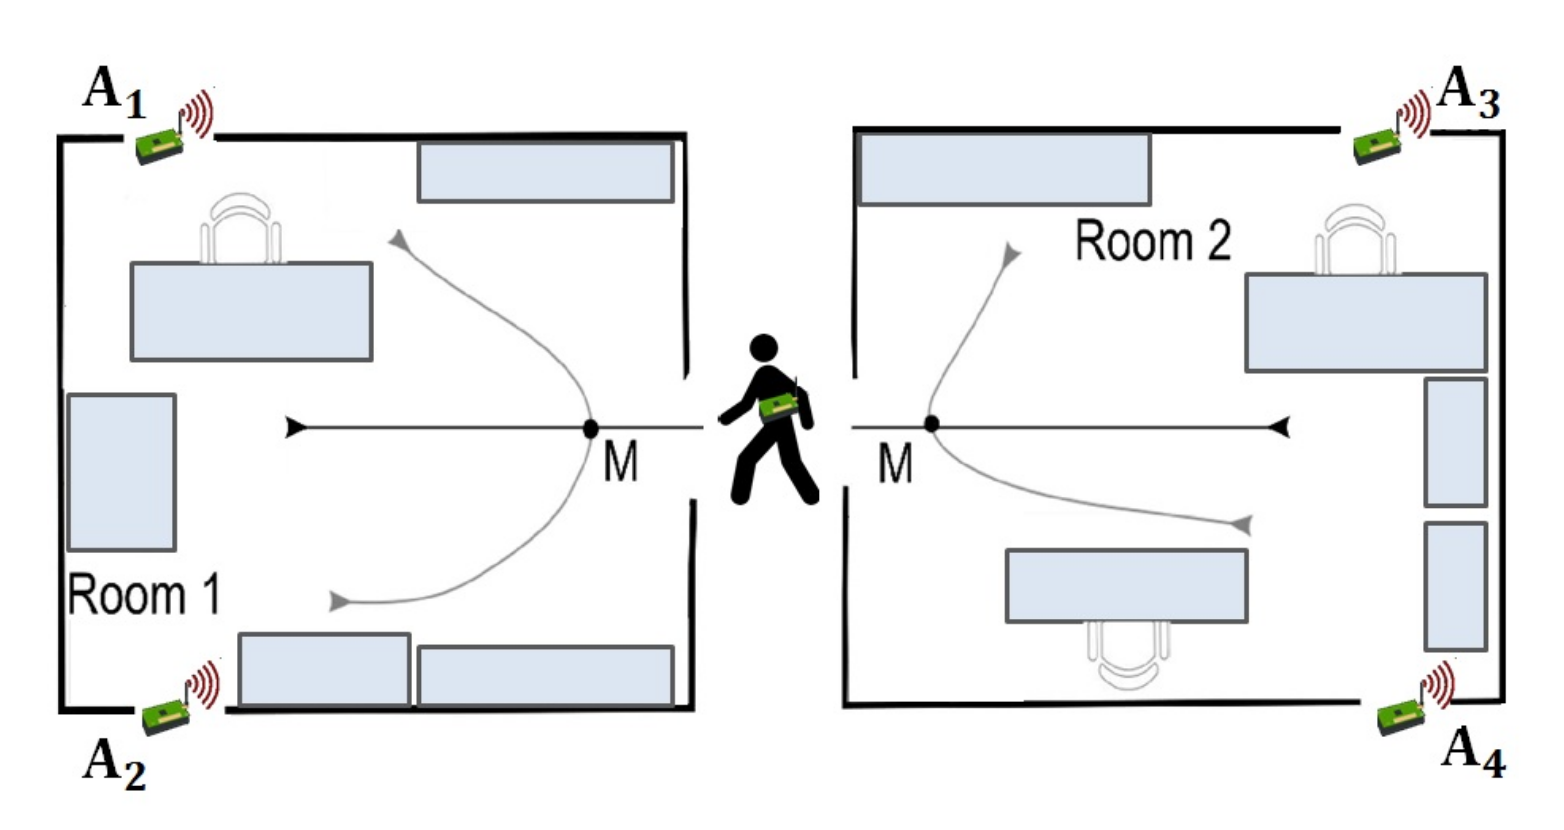

In [2]:
Image('Sensor_overview.png')

From (https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/)


A person can move along any of the six pre-defined paths shown in the above image. If a person walks on path 2, 3, 4 or 6, he moves within the room. On the other hand, if a person follows path 1 or path 5, we can say that the person has moved between the rooms.

The sensor reading can be used to identify the position of a person at a given point in time. As the person moves in the room or across rooms, the reading in the sensor changes. This change can be used to identify the path of the person.

In [3]:
df1 = pd.read_csv('dataset/MovementAAL_RSS_1.csv')
df2 = pd.read_csv('dataset/MovementAAL_RSS_2.csv')
display(df1.head())
display(df2.head())

,#RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


,#RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
0,-0.57143,-0.20,0.71429,0.50
1,-0.76190,-0.48,0.76190,-0.25
2,-0.85714,-0.60,0.85714,0.55
3,-0.76190,-0.40,0.71429,0.60
4,-0.76190,-0.84,0.85714,0.45


In [4]:
df1.shape, df2.shape

((27, 4), (26, 4))

In [5]:
path = 'dataset/MovementAAL_RSS_'
sequences = list()
for i in range(1,315):
    file_path = path + str(i) + '.csv'
    print(file_path)
    df = pd.read_csv(file_path, header=0)
    values = df.values
    sequences.append(values)

dataset/MovementAAL_RSS_1.csv
dataset/MovementAAL_RSS_2.csv
dataset/MovementAAL_RSS_3.csv
dataset/MovementAAL_RSS_4.csv
dataset/MovementAAL_RSS_5.csv
dataset/MovementAAL_RSS_6.csv
dataset/MovementAAL_RSS_7.csv
dataset/MovementAAL_RSS_8.csv
dataset/MovementAAL_RSS_9.csv
dataset/MovementAAL_RSS_10.csv
dataset/MovementAAL_RSS_11.csv
dataset/MovementAAL_RSS_12.csv
dataset/MovementAAL_RSS_13.csv
dataset/MovementAAL_RSS_14.csv
dataset/MovementAAL_RSS_15.csv
dataset/MovementAAL_RSS_16.csv
dataset/MovementAAL_RSS_17.csv
dataset/MovementAAL_RSS_18.csv
dataset/MovementAAL_RSS_19.csv
dataset/MovementAAL_RSS_20.csv
dataset/MovementAAL_RSS_21.csv
dataset/MovementAAL_RSS_22.csv
dataset/MovementAAL_RSS_23.csv
dataset/MovementAAL_RSS_24.csv
dataset/MovementAAL_RSS_25.csv
dataset/MovementAAL_RSS_26.csv
dataset/MovementAAL_RSS_27.csv
dataset/MovementAAL_RSS_28.csv
dataset/MovementAAL_RSS_29.csv
dataset/MovementAAL_RSS_30.csv
dataset/MovementAAL_RSS_31.csv
dataset/MovementAAL_RSS_32.csv
dataset/MovementA

dataset/MovementAAL_RSS_308.csv
dataset/MovementAAL_RSS_309.csv
dataset/MovementAAL_RSS_310.csv
dataset/MovementAAL_RSS_311.csv
dataset/MovementAAL_RSS_312.csv
dataset/MovementAAL_RSS_313.csv
dataset/MovementAAL_RSS_314.csv


In [6]:
targets = pd.read_csv('dataset/MovementAAL_target.csv')
targets = targets.values[:,1]

In [7]:
sequences[0]

array([[-0.90476 , -0.48    ,  0.28571 ,  0.3     ],
       [-0.57143 , -0.32    ,  0.14286 ,  0.3     ],
       [-0.38095 , -0.28    , -0.14286 ,  0.35    ],
       [-0.28571 , -0.2     , -0.47619 ,  0.35    ],
       [-0.14286 , -0.2     ,  0.14286 , -0.2     ],
       [-0.14286 , -0.2     ,  0.047619,  0.      ],
       [-0.14286 , -0.16    , -0.38095 ,  0.2     ],
       [-0.14286 , -0.04    , -0.61905 , -0.2     ],
       [-0.095238, -0.08    ,  0.14286 , -0.55    ],
       [-0.047619,  0.04    , -0.095238,  0.05    ],
       [-0.19048 , -0.04    ,  0.095238,  0.4     ],
       [-0.095238, -0.04    , -0.14286 ,  0.35    ],
       [-0.33333 , -0.08    , -0.28571 , -0.2     ],
       [-0.2381  ,  0.04    ,  0.14286 ,  0.35    ],
       [ 0.      ,  0.08    ,  0.14286 ,  0.05    ],
       [-0.095238,  0.04    ,  0.095238,  0.1     ],
       [-0.14286 , -0.2     ,  0.14286 ,  0.5     ],
       [-0.19048 ,  0.04    , -0.42857 ,  0.3     ],
       [-0.14286 , -0.08    , -0.2381  ,  0.15

In [8]:
groups = pd.read_csv('groups/MovementAAL_DatasetGroup.csv', header=0)
groups = groups.values[:,1]

In [9]:
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    314.000000
mean      42.028662
std       16.185303
min       19.000000
25%       26.000000
50%       41.000000
75%       56.000000
max      129.000000
dtype: float64

In [10]:
#Padding the sequence with the values in last row to max length
to_pad = 129
new_seq = []
for one_seq in sequences:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(4, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)

#truncate the sequence to length 60
from keras.preprocessing import sequence
seq_len = 60
final_seq=sequence.pad_sequences(final_seq, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [11]:
train = [final_seq[i] for i in range(len(groups)) if (groups[i]==2)]
validation = [final_seq[i] for i in range(len(groups)) if groups[i]==1]
test = [final_seq[i] for i in range(len(groups)) if groups[i]==3]

train_target = [targets[i] for i in range(len(groups)) if (groups[i]==2)]
validation_target = [targets[i] for i in range(len(groups)) if groups[i]==1]
test_target = [targets[i] for i in range(len(groups)) if groups[i]==3]
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
train_target = (train_target+1)/2

validation_target = np.array(validation_target)
validation_target = (validation_target+1)/2

test_target = np.array(test_target)
test_target = (test_target+1)/2

In [12]:
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, 4)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0803 19:58:49.480655 140621236832000 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 19:58:49.500429 140621236832000 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 19:58:49.502761 140621236832000 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 19:58:49.798113 140621236832000 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:136: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0803 19:58:49.804457 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [19]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
#reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train, train_target, epochs=200, batch_size=128, 
          callbacks=[chk], validation_data=(validation,validation_target), shuffle=True)

Train on 106 samples, validate on 104 samples
Epoch 1/200
106/106 [==============================] - 1s 12ms/step - loss: 0.1679 - acc: 0.9623 - val_loss: 1.0631 - val_acc: 0.5962

Epoch 00001: val_acc improved from -inf to 0.59615, saving model to best_model.h5
Epoch 2/200
106/106 [==============================] - 0s 1ms/step - loss: 0.1356 - acc: 0.9717 - val_loss: 1.3307 - val_acc: 0.5962

Epoch 00002: val_acc did not improve from 0.59615
Epoch 3/200
106/106 [==============================] - 0s 1ms/step - loss: 0.1301 - acc: 0.9623 - val_loss: 1.4533 - val_acc: 0.6058

Epoch 00003: val_acc improved from 0.59615 to 0.60577, saving model to best_model.h5
Epoch 4/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0944 - acc: 0.9717 - val_loss: 1.5499 - val_acc: 0.5865

Epoch 00004: val_acc did not improve from 0.60577
Epoch 5/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0612 - acc: 0.9811 - val_loss: 1.7042 - val_acc: 0.5962

Epoch 00005: val


Epoch 00043: val_acc did not improve from 0.68269
Epoch 44/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0262 - acc: 1.0000 - val_loss: 2.2037 - val_acc: 0.6154

Epoch 00044: val_acc did not improve from 0.68269
Epoch 45/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0254 - acc: 1.0000 - val_loss: 2.2058 - val_acc: 0.6154

Epoch 00045: val_acc did not improve from 0.68269
Epoch 46/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0198 - acc: 1.0000 - val_loss: 2.1436 - val_acc: 0.6346

Epoch 00046: val_acc did not improve from 0.68269
Epoch 47/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0757 - acc: 0.9906 - val_loss: 2.3129 - val_acc: 0.5865

Epoch 00047: val_acc did not improve from 0.68269
Epoch 48/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0319 - acc: 0.9906 - val_loss: 2.5117 - val_acc: 0.5288

Epoch 00048: val_acc did not improve from 0.68269
Epoch 49/200
106/106 [==

106/106 [==============================] - 0s 1ms/step - loss: 0.1101 - acc: 0.9623 - val_loss: 1.8107 - val_acc: 0.5096

Epoch 00088: val_acc did not improve from 0.68269
Epoch 89/200
106/106 [==============================] - 0s 1ms/step - loss: 0.1030 - acc: 0.9623 - val_loss: 1.8386 - val_acc: 0.5192

Epoch 00089: val_acc did not improve from 0.68269
Epoch 90/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0814 - acc: 0.9906 - val_loss: 1.8438 - val_acc: 0.5288

Epoch 00090: val_acc did not improve from 0.68269
Epoch 91/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0815 - acc: 0.9906 - val_loss: 1.8491 - val_acc: 0.5096

Epoch 00091: val_acc did not improve from 0.68269
Epoch 92/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0714 - acc: 0.9906 - val_loss: 1.8390 - val_acc: 0.5288

Epoch 00092: val_acc did not improve from 0.68269
Epoch 93/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0569 - acc


Epoch 00132: val_acc did not improve from 0.68269
Epoch 133/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 2.6369 - val_acc: 0.5192

Epoch 00133: val_acc did not improve from 0.68269
Epoch 134/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 2.6518 - val_acc: 0.5096

Epoch 00134: val_acc did not improve from 0.68269
Epoch 135/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 2.6659 - val_acc: 0.5096

Epoch 00135: val_acc did not improve from 0.68269
Epoch 136/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 2.6836 - val_acc: 0.5096

Epoch 00136: val_acc did not improve from 0.68269
Epoch 137/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 2.7231 - val_acc: 0.5000

Epoch 00137: val_acc did not improve from 0.68269
Epoch 138/200
106/1

106/106 [==============================] - 0s 1ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 3.0096 - val_acc: 0.5192

Epoch 00177: val_acc did not improve from 0.68269
Epoch 178/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 3.0106 - val_acc: 0.5192

Epoch 00178: val_acc did not improve from 0.68269
Epoch 179/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 3.0123 - val_acc: 0.5192

Epoch 00179: val_acc did not improve from 0.68269
Epoch 180/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 3.0131 - val_acc: 0.5192

Epoch 00180: val_acc did not improve from 0.68269
Epoch 181/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 3.0131 - val_acc: 0.5192

Epoch 00181: val_acc did not improve from 0.68269
Epoch 182/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0019 

In [20]:
#loading the model and checking accuracy on the test data
model = load_model('best_model.h5')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

0.7019230769230769

In [21]:
modelRNN = Sequential()
modelRNN.add(SimpleRNN(256, input_shape=(seq_len, 4)))
modelRNN.add(Dropout(0.2))
modelRNN.add(Dense(1, activation='sigmoid'))
modelRNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 256)               66816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 67,073
Trainable params: 67,073
Non-trainable params: 0
_________________________________________________________________


In [22]:
chkRNN = ModelCheckpoint('best_modelRNN.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
historyRNN = model.fit(train, train_target, epochs=200, batch_size=128, 
          callbacks=[chkRNN], validation_data=(validation,validation_target), shuffle=True)

Train on 106 samples, validate on 104 samples
Epoch 1/200
106/106 [==============================] - 1s 14ms/step - loss: 0.0387 - acc: 0.9906 - val_loss: 2.3161 - val_acc: 0.5481

Epoch 00001: val_acc improved from -inf to 0.54808, saving model to best_modelRNN.h5
Epoch 2/200
106/106 [==============================] - 0s 1ms/step - loss: 0.2231 - acc: 0.9245 - val_loss: 2.0118 - val_acc: 0.5288

Epoch 00002: val_acc did not improve from 0.54808
Epoch 3/200
106/106 [==============================] - 0s 2ms/step - loss: 0.8628 - acc: 0.7642 - val_loss: 1.8117 - val_acc: 0.5096

Epoch 00003: val_acc did not improve from 0.54808
Epoch 4/200
106/106 [==============================] - 0s 2ms/step - loss: 0.2428 - acc: 0.9057 - val_loss: 1.3201 - val_acc: 0.5865

Epoch 00004: val_acc improved from 0.54808 to 0.58654, saving model to best_modelRNN.h5
Epoch 5/200
106/106 [==============================] - 0s 1ms/step - loss: 0.1747 - acc: 0.9528 - val_loss: 1.1585 - val_acc: 0.6346

Epoch 0000


Epoch 00044: val_acc did not improve from 0.64423
Epoch 45/200
106/106 [==============================] - 0s 1ms/step - loss: 0.2926 - acc: 0.8962 - val_loss: 1.7362 - val_acc: 0.5865

Epoch 00045: val_acc did not improve from 0.64423
Epoch 46/200
106/106 [==============================] - 0s 2ms/step - loss: 0.3193 - acc: 0.9057 - val_loss: 1.4949 - val_acc: 0.6250

Epoch 00046: val_acc did not improve from 0.64423
Epoch 47/200
106/106 [==============================] - 0s 2ms/step - loss: 0.3981 - acc: 0.8774 - val_loss: 1.5097 - val_acc: 0.6058

Epoch 00047: val_acc did not improve from 0.64423
Epoch 48/200
106/106 [==============================] - 0s 2ms/step - loss: 0.4229 - acc: 0.8585 - val_loss: 1.4688 - val_acc: 0.5962

Epoch 00048: val_acc did not improve from 0.64423
Epoch 49/200
106/106 [==============================] - 0s 1ms/step - loss: 0.5045 - acc: 0.8962 - val_loss: 1.4465 - val_acc: 0.5769

Epoch 00049: val_acc did not improve from 0.64423
Epoch 50/200
106/106 [==

106/106 [==============================] - 0s 1ms/step - loss: 0.0775 - acc: 0.9623 - val_loss: 1.3356 - val_acc: 0.5481

Epoch 00089: val_acc did not improve from 0.64423
Epoch 90/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0805 - acc: 0.9623 - val_loss: 1.2755 - val_acc: 0.5769

Epoch 00090: val_acc did not improve from 0.64423
Epoch 91/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0854 - acc: 0.9528 - val_loss: 1.2940 - val_acc: 0.5865

Epoch 00091: val_acc did not improve from 0.64423
Epoch 92/200
106/106 [==============================] - 0s 2ms/step - loss: 0.1278 - acc: 0.9528 - val_loss: 1.2991 - val_acc: 0.5865

Epoch 00092: val_acc did not improve from 0.64423
Epoch 93/200
106/106 [==============================] - 0s 1ms/step - loss: 0.1317 - acc: 0.9528 - val_loss: 1.2897 - val_acc: 0.5962

Epoch 00093: val_acc did not improve from 0.64423
Epoch 94/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0809 - acc

106/106 [==============================] - 0s 1ms/step - loss: 0.0184 - acc: 1.0000 - val_loss: 1.5749 - val_acc: 0.6538

Epoch 00133: val_acc did not improve from 0.65385
Epoch 134/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0477 - acc: 0.9811 - val_loss: 2.1856 - val_acc: 0.6538

Epoch 00134: val_acc did not improve from 0.65385
Epoch 135/200
106/106 [==============================] - 0s 1ms/step - loss: 0.2106 - acc: 0.9717 - val_loss: 2.3633 - val_acc: 0.6154

Epoch 00135: val_acc did not improve from 0.65385
Epoch 136/200
106/106 [==============================] - 0s 1ms/step - loss: 0.2379 - acc: 0.9623 - val_loss: 2.4345 - val_acc: 0.6154

Epoch 00136: val_acc did not improve from 0.65385
Epoch 137/200
106/106 [==============================] - 0s 1ms/step - loss: 0.1992 - acc: 0.9623 - val_loss: 2.4547 - val_acc: 0.5577

Epoch 00137: val_acc did not improve from 0.65385
Epoch 138/200
106/106 [==============================] - 0s 1ms/step - loss: 0.1480 


Epoch 00176: val_acc did not improve from 0.71154
Epoch 177/200
106/106 [==============================] - 0s 2ms/step - loss: 0.1471 - acc: 0.9528 - val_loss: 1.1280 - val_acc: 0.6058

Epoch 00177: val_acc did not improve from 0.71154
Epoch 178/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0875 - acc: 0.9811 - val_loss: 1.3105 - val_acc: 0.5962

Epoch 00178: val_acc did not improve from 0.71154
Epoch 179/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0925 - acc: 0.9906 - val_loss: 1.3582 - val_acc: 0.5769

Epoch 00179: val_acc did not improve from 0.71154
Epoch 180/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0808 - acc: 0.9717 - val_loss: 1.4450 - val_acc: 0.5865

Epoch 00180: val_acc did not improve from 0.71154
Epoch 181/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0537 - acc: 0.9906 - val_loss: 1.6017 - val_acc: 0.6154

Epoch 00181: val_acc did not improve from 0.71154
Epoch 182/200
106/1

In [23]:
#loading the model and checking accuracy on the test data
modelRNN = load_model('best_modelRNN.h5')

from sklearn.metrics import accuracy_score
test_predsRNN = modelRNN.predict_classes(test)
accuracy_score(test_target, test_predsRNN)

0.6346153846153846

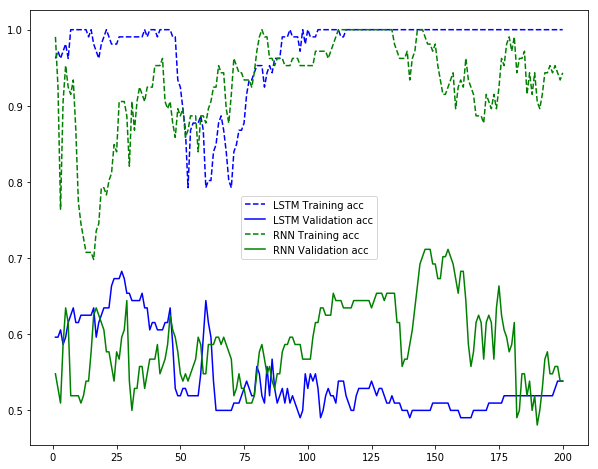

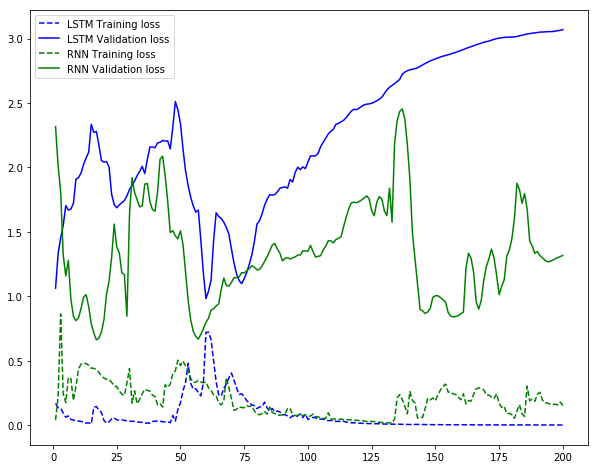

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
accRNN = historyRNN.history['acc']
val_accRNN = historyRNN.history['val_acc']
lossRNN = historyRNN.history['loss']
val_lossRNN = historyRNN.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(epochs, acc, 'b--', label='LSTM Training acc')
plt.plot(epochs, val_acc, 'b', label='LSTM Validation acc')
plt.plot(epochs, accRNN, 'g--', label='RNN Training acc')
plt.plot(epochs, val_accRNN, 'g', label='RNN Validation acc')
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'b--', label='LSTM Training loss')
plt.plot(epochs, val_loss, 'b', label='LSTM Validation loss')
plt.plot(epochs, lossRNN, 'g--', label='RNN Training loss')
plt.plot(epochs, val_lossRNN, 'g', label='RNN Validation loss')
plt.legend()
plt.show()

In [25]:
model